<a href="https://colab.research.google.com/github/beyzoskaya/AutomataTheory/blob/main/comparison_graph_models/baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

In [2]:
!pip install pandas scikit-learn scipy

In [3]:
import torch
print(torch.__version__)

2.6.0+cu124


In [4]:
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [5]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [6]:
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [7]:
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [8]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [9]:
!pip install torch-geometric-temporal -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [10]:
!pip install torch_geometric

In [11]:
import torch_geometric_temporal.nn.attention as attn
print(dir(attn))

['AAGCN', 'ASTGCN', 'ChebConvAttention', 'DNNTSP', 'GMAN', 'GraphAAGCN', 'GraphConstructor', 'MSTGCN', 'MTGNN', 'MixProp', 'STConv', 'SpatioTemporalAttention', 'SpatioTemporalEmbedding', 'TemporalConv', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'astgcn', 'dnntsp', 'gman', 'mstgcn', 'mtgnn', 'stgcn', 'tsagcn']


In [12]:
from torch_geometric_temporal.nn.attention import ASTGCN

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch_geometric_temporal.nn.attention import ASTGCN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from scipy.stats import spearmanr, pearsonr

In [78]:
csv_path = '/content/gene_expression_over_time_mirna.csv'

df = pd.read_csv(csv_path)
df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
print(f"Shape: {df.shape}")

data = df.values  # shape: (num_nodes, num_timepoints)
num_nodes, num_timepoints = data.shape

scaler = StandardScaler()
data = scaler.fit_transform(data.T).T

Shape: (162, 159)


In [79]:
data

array([[ 0.39997747, -0.40668215, -0.33257208, ..., -0.3739027 ,
         0.90164564,  2.88694042],
       [ 0.37406212, -0.27670949, -0.86240394, ..., -0.83451373,
        -0.7647882 ,  0.43913928],
       [ 0.25450014,  0.73056512,  0.01646766, ..., -0.93566229,
         2.63482502, -0.69762981],
       ...,
       [-1.38460892, -0.33403874, -0.56749878, ..., -0.80095882,
        -0.6842288 ,  0.01615132],
       [ 1.38798303,  0.15753019, -0.52090442, ..., -0.67681797,
        -0.30178268,  3.20416513],
       [ 1.4755297 , -0.05922995, -0.60214654, ..., -0.85196237,
        -0.83093827, -0.16806061]])

In [80]:
print(df.columns)  # Confirm 'Time_154.0' is gone

Index(['Time_1.0', 'Time_2.0', 'Time_3.0', 'Time_4.0', 'Time_5.0', 'Time_6.0',
       'Time_7.0', 'Time_8.0', 'Time_9.0', 'Time_10.0',
       ...
       'Time_150.0', 'Time_151.0', 'Time_152.0', 'Time_153.0', 'Time_155.0',
       'Time_156.0', 'Time_157.0', 'Time_158.0', 'Time_159.0', 'Time_160.0'],
      dtype='object', length=159)


In [81]:
print(f"Data shape: {data.shape}")
print(f"Sample data (first 5 genes, first 5 time points):\n{data[:5, :5]}")

Data shape: (162, 159)
Sample data (first 5 genes, first 5 time points):
[[ 0.39997747 -0.40668215 -0.33257208  0.17622206 -0.76013018]
 [ 0.37406212 -0.27670949 -0.86240394 -0.62998551 -0.22092907]
 [ 0.25450014  0.73056512  0.01646766 -0.45959732 -0.22156483]
 [-0.93906724 -1.06756267  1.11685966 -0.03959922  1.11685966]
 [ 0.94011968 -0.09055213 -0.6467817  -0.59433936 -0.19922326]]


In [82]:
corr = np.corrcoef(data)
threshold = 0.1
adj = (np.abs(corr) > threshold).astype(float)
np.fill_diagonal(adj, 1)
print(adj)
# Convert to edge_index & edge_weight
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Num edges: 25358


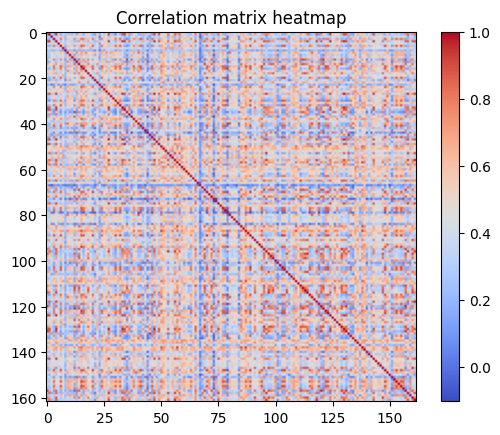

In [83]:
import matplotlib.pyplot as plt
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.title("Correlation matrix heatmap")
plt.show()

In [84]:
seq_len = 3
pred_len = 1

features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len):
    x = data[:, t:t+seq_len]                # (num_nodes, seq_len)
    y = data[:, t+seq_len:t+seq_len+pred_len]  # (num_nodes, pred_len)
    features.append(x[:, :, None])          # add feature dim: (num_nodes, seq_len, 1)
    targets.append(y)

print(f"Num samples: {len(features)}")

Num samples: 155


In [85]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

In [72]:
dataset

In [86]:
train_size = int(0.8 * len(features))
train_dataset = list(dataset)[:train_size]
test_dataset = list(dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 124, Test samples: 31


In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ASTGCN(
    nb_block=2,
    in_channels=1,
    K=3,
    nb_chev_filter=8,
    nb_time_filter=8,
    time_strides=1,
    num_for_predict=pred_len,
    len_input=seq_len,
    num_of_vertices=num_nodes
).to(device)

In [94]:
print("Adjacency matrix shape:", adj.shape)
print("Number of edges:", edge_index.shape[1])
print("Edge weights:", edge_weight)
print("Are there isolated nodes?")

# Degree of each node
degrees = adj.sum(axis=1)
print(degrees)

isolated_nodes = np.where(degrees == 0)[0]
print("Isolated nodes:", isolated_nodes)


Adjacency matrix shape: (162, 162)
Number of edges: 25358
Edge weights: tensor([1., 1., 1.,  ..., 1., 1., 1.])
Are there isolated nodes?
[162. 160. 158. 156. 162. 161. 157. 159. 154. 160. 156. 158. 155. 149.
 162. 161. 156. 160. 161. 160. 159. 145. 162. 151. 160. 159. 161. 162.
 159. 159. 140. 162. 156. 162. 159. 136. 162. 150. 162. 162. 153. 157.
 152. 154. 119. 159. 153. 162. 158. 161. 160. 162. 162. 160. 161. 161.
 160. 162. 153. 161. 160. 161. 154. 157. 162. 159. 161.  94. 150. 162.
 156. 162. 161.  97. 154. 161. 162. 159. 153. 103. 160. 161. 160. 161.
 124. 162. 161. 159. 158. 158. 160. 162. 161. 162. 159. 162. 158. 161.
 162. 162. 158. 136. 157. 155. 156. 162. 156. 160. 156. 160. 161. 156.
 160. 162. 162. 155. 157. 160. 162. 150. 161. 146. 161. 157. 162. 160.
 159. 162. 160. 161. 162. 155. 156. 154. 146. 161. 162. 160. 162. 162.
 153. 161. 156. 162. 161. 161. 160. 162. 158. 161. 153. 135. 156. 161.
 161. 158. 152. 157. 157. 156. 162. 159.]
Isolated nodes: []


In [89]:
print("Number of nonzero entries in adjacency:", np.count_nonzero(adj))
print("Sample adjacency (10x10):")
print(adj[:10, :10])

Number of nonzero entries in adjacency: 25358
Sample adjacency (10x10):
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [95]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 15

for epoch in range(epochs):
    model.train()
    losses = []
    for snapshot in train_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        #print(f"x shape: {x.shape}")
        x = x.permute(0, 1, 3, 2)  # fix shape for ASTGCN
        #print(f"x shape after permute: {x.shape}")
        y = snapshot.y.clone().detach().float().to(device)
        #print(f"y shape: {y.shape}")

        edge_index = snapshot.edge_index.to(device)

        pred = model(x, edge_index)
        loss = criterion(pred.squeeze(0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")


Epoch 1/15, Loss: 0.9833
Epoch 2/15, Loss: 0.9431
Epoch 3/15, Loss: 0.9446
Epoch 4/15, Loss: 0.9429
Epoch 5/15, Loss: 0.9404
Epoch 6/15, Loss: 0.9381
Epoch 7/15, Loss: 0.9361
Epoch 8/15, Loss: 0.9343
Epoch 9/15, Loss: 0.9328
Epoch 10/15, Loss: 0.9314
Epoch 11/15, Loss: 0.9302
Epoch 12/15, Loss: 0.9292
Epoch 13/15, Loss: 0.9282
Epoch 14/15, Loss: 0.9274
Epoch 15/15, Loss: 0.9266


In [96]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

model.eval()
pearson_scores = []
spearman_scores = []

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        x = x.permute(0, 1, 3, 2)  # shape fix for ASTGCN
        y_true = snapshot.y.clone().detach().float().cpu().numpy()
        print(f"y_true shape: {y_true.shape}")

        edge_index = snapshot.edge_index.to(device)
        print(f"edge_index shape: {edge_index.shape}")

        y_pred = model(x, edge_index).squeeze(0).cpu().numpy()
        print(f"y_pred shape: {y_pred.shape}")

        print(f"Example y_true: {y_true[0]}")
        print(f"Example y_pred: {y_pred[0]}")

        y_true_flat = y_true.flatten()
        print(f"y_true_flat: {y_true_flat.shape}")
        y_pred_flat = y_pred.flatten()
        print(f"y_pred_flat: {y_pred_flat.shape}")

        try:
            p_corr, _ = pearsonr(y_true_flat, y_pred_flat)
        except:
            print("Nan in pearson")
            p_corr = np.nan
        try:
            s_corr, _ = spearmanr(y_true_flat, y_pred_flat)
        except:
            print("Nan in spearman")
            s_corr = np.nan

        pearson_scores.append(p_corr)
        spearman_scores.append(s_corr)

mean_pearson = np.nanmean(pearson_scores)
mean_spearman = np.nanmean(spearman_scores)

print(f"Mean Pearson correlation on test set: {mean_pearson:.4f}")
print(f"Mean Spearman correlation on test set: {mean_spearman:.4f}")

y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.47936702]
Example y_pred: [-0.15126792]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.11166706]
Example y_pred: [-0.1301097]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [2.00047]
Example y_pred: [-0.11390302]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.23138332]
Example y_pred: [0.11377835]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.9610825]
Example y_pred: [-0.17348608]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred s

mrna pred

In [43]:
csv_path = '/content/gene_expression_over_time.csv'

df = pd.read_csv(csv_path)
df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
print(f"Shape: {df.shape}")

data = df.values  # shape: (num_nodes, num_timepoints)
num_nodes, num_timepoints = data.shape

Shape: (50, 43)


In [44]:
print(f"Data shape: {data.shape}")
print(f"Sample data (first 5 genes, first 5 time points):\n{data[:5, :5]}")

Data shape: (50, 43)
Sample data (first 5 genes, first 5 time points):
[[ 8.43285714  7.68325     7.5535      7.5965      8.3614    ]
 [ 9.04357143 12.12725    11.7425     12.381      12.381     ]
 [ 6.81751786  6.68440625  6.5048125   6.6175      6.406375  ]
 [ 4.92214286  5.762       6.0735      5.765       5.7526    ]
 [ 6.15665714  4.949375    5.43265     5.4099      5.65982   ]]


In [57]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# data shape: (num_nodes, num_timepoints)
similarity = cosine_similarity(data)  # or use other similarity/distance metrics

k = 5  # number of neighbors

adj = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    # Get indices of top k neighbors excluding itself
    neighbors = np.argsort(similarity[i])[-(k+1):-1]
    adj[i, neighbors] = similarity[i, neighbors]

# Symmetrize adjacency
adj = np.maximum(adj, adj.T)

# Optional: normalize adjacency (row sum to 1)
adj = adj / (adj.sum(axis=1, keepdims=True) + 1e-10)

# Convert to edge_index and edge_weight
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")


Num edges: 397


In [58]:
seq_len = 3
pred_len = 1

features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len):
    x = data[:, t:t+seq_len]                # (num_nodes, seq_len)
    y = data[:, t+seq_len:t+seq_len+pred_len]  # (num_nodes, pred_len)
    features.append(x[:, :, None])          # add feature dim: (num_nodes, seq_len, 1)
    targets.append(y)

print(f"Num samples: {len(features)}")

Num samples: 39


In [59]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

In [60]:
train_size = int(0.8 * len(features))
train_dataset = list(dataset)[:train_size]
test_dataset = list(dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 31, Test samples: 8


In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ASTGCN(
    nb_block=2,
    in_channels=1,
    K=3,
    nb_chev_filter=2,
    nb_time_filter=2,
    time_strides=1,
    num_for_predict=pred_len,
    len_input=seq_len,
    num_of_vertices=num_nodes
).to(device)

In [73]:
print("Adjacency matrix shape:", adj.shape)
print("Number of edges:", edge_index.shape[1])
print("Edge weights:", edge_weight)
print("Are there isolated nodes?")

# Degree of each node
degrees = adj.sum(axis=1)
print(degrees)

isolated_nodes = np.where(degrees == 0)[0]
print("Isolated nodes:", isolated_nodes)

Adjacency matrix shape: (50, 50)
Number of edges: 397
Edge weights: None
Are there isolated nodes?
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Isolated nodes: []


In [74]:
print("Number of nonzero entries in adjacency:", np.count_nonzero(adj))
print("Sample adjacency (10x10):")
print(adj[:10, :10])

Number of nonzero entries in adjacency: 397
Sample adjacency (10x10):
[[0.         0.         0.11120115 0.         0.11106327 0.
  0.         0.         0.11116045 0.        ]
 [0.         0.         0.12501651 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.06668753 0.06665568 0.         0.         0.06663671 0.06661465
  0.06666051 0.06670203 0.0666584  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.19995301]
 [0.19992462 0.         0.20002027 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.16666625 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.10008115 0.         0.         0.
  0.         0.10008587 0.10011992 0.        ]
 [0.         0.         0.12518073 0.         0.         0.
  0.12510872 0.         0.         0.        ]
 [0.11134563 0.         0.11133773 0.         0.         0.
  0.11

In [75]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 10

for epoch in range(epochs):
    model.train()
    losses = []
    for snapshot in train_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        #print(f"x shape: {x.shape}")
        x = x.permute(0, 1, 3, 2)  # fix shape for ASTGCN
        #print(f"x shape after permute: {x.shape}")
        y = snapshot.y.clone().detach().float().to(device)
        #print(f"y shape: {y.shape}")

        edge_index = snapshot.edge_index.to(device)

        pred = model(x, edge_index)
        loss = criterion(pred.squeeze(0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")


Epoch 1/10, Loss: 53.1326
Epoch 2/10, Loss: 52.7209
Epoch 3/10, Loss: 52.3126
Epoch 4/10, Loss: 51.9071
Epoch 5/10, Loss: 51.5042
Epoch 6/10, Loss: 51.1037
Epoch 7/10, Loss: 50.7056
Epoch 8/10, Loss: 50.3098
Epoch 9/10, Loss: 49.9163
Epoch 10/10, Loss: 49.5249


In [76]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

model.eval()
pearson_scores = []
spearman_scores = []

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        x = x.permute(0, 1, 3, 2)  # shape fix for ASTGCN
        y_true = snapshot.y.clone().detach().float().cpu().numpy()
        print(f"y_true shape: {y_true.shape}")

        edge_index = snapshot.edge_index.to(device)
        print(f"edge_index shape: {edge_index.shape}")

        y_pred = model(x, edge_index).squeeze(0).cpu().numpy()
        print(f"y_pred shape: {y_pred.shape}")

        print(f"Example y_true: {y_true[0]}")
        print(f"Example y_pred: {y_pred[0]}")

        y_true_flat = y_true.flatten()
        print(f"y_true_flat: {y_true_flat.shape}")
        y_pred_flat = y_pred.flatten()
        print(f"y_pred_flat: {y_pred_flat.shape}")

        pearson, _ = pearsonr(y_true_flat, y_pred_flat)
        print(f"Pearson: {pearson}")
        spearman, _ = spearmanr(y_true_flat, y_pred_flat)
        spearman = print(f"Spearman: {spearman}")


        try:
            p_corr, _ = pearsonr(y_true_flat, y_pred_flat)
        except:
            print("Nan in pearson")
            p_corr = np.nan
        try:
            s_corr, _ = spearmanr(y_true_flat, y_pred_flat)
        except:
            print("Nan in spearman")
            s_corr = np.nan

        pearson_scores.append(p_corr)
        spearman_scores.append(s_corr)

mean_pearson = np.nanmean(pearson_scores)
mean_spearman = np.nanmean(spearman_scores)

print(f"Mean Pearson correlation on test set: {mean_pearson:.4f}")
print(f"Mean Spearman correlation on test set: {mean_spearman:.4f}")

y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.199833]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.4720931053161621
Spearman: 0.5752977333845563
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.293625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.46522536873817444
Spearman: 0.5728486361890127
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.004625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.4723204970359802
Spearman: 0.5982520169035729
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.14625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.45424410700798035
Spearman: 0.5446119861698041
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_

In [66]:
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [68]:
import inspect
from torch_geometric_temporal.nn.recurrent import DCRNN
print(inspect.signature(DCRNN.__init__))

(self, in_channels: int, out_channels: int, K: int, bias: bool = True)


training DCRNN for mirna

In [152]:
csv_path = '/content/gene_expression_over_time_mirna.csv'
df = pd.read_csv(csv_path)

df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
data = df.values  # shape: (num_nodes, num_timepoints)
print(f"Shape: {df.shape}")
num_nodes, num_timepoints = data.shape

Shape: (162, 159)


In [153]:
corr = np.corrcoef(data)
threshold = 0.1
adj = (np.abs(corr) > threshold).astype(float)
np.fill_diagonal(adj, 1)
print(adj)
# Convert to edge_index & edge_weight
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Num edges: 25358


In [154]:
seq_len = 10
pred_len = 1
features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len):
    x = data[:, t:t+seq_len]                # (num_nodes, seq_len)
    y = data[:, t+seq_len:t+seq_len+pred_len]  # (num_nodes, pred_len)
    features.append(x[:, :, None])          # (num_nodes, seq_len, 1)
    targets.append(y)

In [155]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)


In [156]:
train_size = int(0.8 * len(features))
train_dataset = list(dataset)[:train_size]
test_dataset = list(dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 118, Test samples: 30


In [160]:
model = DCRNN(
    in_channels=10,      # seq_len = 3 (number of time steps)
    out_channels=1,     # predicting 1 time step ahead
    K=4                # Reduce K to 2 (diffusion steps)
).to(device)

In [134]:
import torch_geometric_temporal
print(torch_geometric_temporal.__version__)

0.54.0


In [115]:
!pip install --upgrade torch-geometric-temporal

In [165]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 30
for epoch in range(epochs):
    model.train()
    losses = []
    for snapshot in train_dataset:
        x = snapshot.x.clone().detach().float().to(device)  # (num_nodes, seq_len, 1)
        #print(f"x shape original: {x.shape}")

        # Try different reshaping - flatten the sequence dimension
        x = x.squeeze(-1)  # Remove last dimension: (162, 3)
        #print(f"x shape after squeeze: {x.shape}")

        y = snapshot.y.clone().detach().float().to(device)  # (num_nodes, pred_len)
        y = y.squeeze(-1) if y.dim() > 1 else y  # Make sure y is (162,) if needed
        #print(f"y shape: {y.shape}")

        edge_index = snapshot.edge_index.to(device)
        if hasattr(snapshot, 'edge_weight') and snapshot.edge_weight is not None:
            edge_weight = snapshot.edge_weight.to(device)
        else:
            edge_weight = torch.ones(edge_index.size(1), device=device)

        # Pass tensor to DCRNN
        pred = model(x, edge_index, edge_weight)
        #print(f"pred shape: {pred.shape}")

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([162])) that is different to the input size (torch.Size([162, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Loss: 376454.1846
Epoch 2/30, Loss: 376454.0549
Epoch 3/30, Loss: 376453.9836
Epoch 4/30, Loss: 376453.7378
Epoch 5/30, Loss: 376453.6979
Epoch 6/30, Loss: 376453.5994
Epoch 7/30, Loss: 376453.6076
Epoch 8/30, Loss: 376453.6430
Epoch 9/30, Loss: 376453.6428
Epoch 10/30, Loss: 376453.6428
Epoch 11/30, Loss: 376453.6428
Epoch 12/30, Loss: 376453.6428
Epoch 13/30, Loss: 376453.6428
Epoch 14/30, Loss: 376453.6428
Epoch 15/30, Loss: 376453.6428
Epoch 16/30, Loss: 376453.6428
Epoch 17/30, Loss: 376453.6428
Epoch 18/30, Loss: 376453.6428
Epoch 19/30, Loss: 376453.6428
Epoch 20/30, Loss: 376453.6428
Epoch 21/30, Loss: 376453.6428
Epoch 22/30, Loss: 376453.6428
Epoch 23/30, Loss: 376453.6428
Epoch 24/30, Loss: 376453.6428
Epoch 25/30, Loss: 376453.6428
Epoch 26/30, Loss: 376453.6428
Epoch 27/30, Loss: 376453.6428
Epoch 28/30, Loss: 376453.6428
Epoch 29/30, Loss: 376453.6428
Epoch 30/30, Loss: 376453.6428


In [162]:
from scipy.stats import pearsonr, spearmanr

# Evaluation
model.eval()
all_predictions = []
all_targets = []

print("Starting evaluation...")

with torch.no_grad():
    for i, snapshot in enumerate(test_dataset):
        x = snapshot.x.clone().detach().float().to(device)  # (162, 3, 1)
        x = x.squeeze(-1)  # (162, 3)

        y = snapshot.y.clone().detach().float().to(device).squeeze(-1)  # (162,)

        edge_index = snapshot.edge_index.to(device)
        if hasattr(snapshot, 'edge_weight') and snapshot.edge_weight is not None:
            edge_weight = snapshot.edge_weight.to(device)
        else:
            edge_weight = torch.ones(edge_index.size(1), device=device)

        pred = model(x, edge_index, edge_weight)
        pred = pred.squeeze()  # Make sure it's 1D: (162,)

        all_predictions.append(pred.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)  # Shape: (num_test_samples, num_nodes)
all_targets = np.array(all_targets)          # Shape: (num_test_samples, num_nodes)

print(f"Predictions shape: {all_predictions.shape}")
print(f"Targets shape: {all_targets.shape}")

# Calculate per-gene correlations
num_genes = all_predictions.shape[1]  # Should be 162
pearson_correlations = []
spearman_correlations = []

print("Calculating correlations per gene...")

for gene_idx in range(num_genes):
    pred_gene = all_predictions[:, gene_idx]  # Predictions for this gene across all test samples
    true_gene = all_targets[:, gene_idx]      # True values for this gene across all test samples

    # Check if we have enough data points and variance
    if len(pred_gene) > 2 and np.std(pred_gene) > 1e-10 and np.std(true_gene) > 1e-10:
        # Calculate Pearson correlation
        try:
            pearson_corr, pearson_p = pearsonr(pred_gene, true_gene)
            if not np.isnan(pearson_corr):
                pearson_correlations.append(pearson_corr)
        except:
            pass

        # Calculate Spearman correlation
        try:
            spearman_corr, spearman_p = spearmanr(pred_gene, true_gene)
            if not np.isnan(spearman_corr):
                spearman_correlations.append(spearman_corr)
        except:
            pass

# Calculate statistics
mean_pearson = np.mean(pearson_correlations) if pearson_correlations else 0.0
std_pearson = np.std(pearson_correlations) if pearson_correlations else 0.0
mean_spearman = np.mean(spearman_correlations) if spearman_correlations else 0.0
std_spearman = np.std(spearman_correlations) if spearman_correlations else 0.0

# Print results
print(f"\n=== DCRNN Evaluation Results ===")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of genes: {num_genes}")
print(f"Valid Pearson correlations: {len(pearson_correlations)}/{num_genes}")
print(f"Valid Spearman correlations: {len(spearman_correlations)}/{num_genes}")
print(f"")
print(f"Mean Pearson correlation: {mean_pearson:.4f} ± {std_pearson:.4f}")
print(f"Mean Spearman correlation: {mean_spearman:.4f} ± {std_spearman:.4f}")

if len(pearson_correlations) > 0:
    print(f"Pearson range: [{np.min(pearson_correlations):.4f}, {np.max(pearson_correlations):.4f}]")
    print(f"Spearman range: [{np.min(spearman_correlations):.4f}, {np.max(spearman_correlations):.4f}]")

# Optional: Save detailed results
results_df = pd.DataFrame({
    'gene_idx': range(len(pearson_correlations)),
    'pearson': pearson_correlations[:len(pearson_correlations)],
    'spearman': spearman_correlations[:len(spearman_correlations)]
})

print(f"\n=== Sample of per-gene results ===")
print(results_df.head(10))


Starting evaluation...
Predictions shape: (30, 162)
Targets shape: (30, 162)
Calculating correlations per gene...

=== DCRNN Evaluation Results ===
Number of test samples: 30
Number of genes: 162
Valid Pearson correlations: 17/162
Valid Spearman correlations: 17/162

Mean Pearson correlation: 0.0575 ± 0.1779
Mean Spearman correlation: 0.0785 ± 0.2197
Pearson range: [-0.3800, 0.2278]
Spearman range: [-0.2904, 0.4016]

=== Sample of per-gene results ===
   gene_idx   pearson  spearman
0         0  0.176620  0.246723
1         1 -0.380031 -0.279010
2         2  0.128302  0.204247
3         3 -0.069815 -0.140565
4         4  0.225996  0.268177
5         5  0.045792 -0.061756
6         6  0.159094  0.246723
7         7  0.227761  0.401620
8         8  0.209048  0.268177
9         9  0.198269  0.268177


/tmp/ipython-input-162-4043126500.py:51: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, pearson_p = pearsonr(pred_gene, true_gene)


In [166]:
from scipy.stats import pearsonr, spearmanr

# Evaluation
model.eval()
pearson_scores = []
spearman_scores = []

print("Starting evaluation...")

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().to(device)  # (162, 3, 1)
        x = x.squeeze(-1)  # (162, 3) - same format as training

        y = snapshot.y.clone().detach().float().to(device)  # (162, 1)
        y = y.squeeze(-1)  # (162,) - same format as training

        edge_index = snapshot.edge_index.to(device)
        if hasattr(snapshot, 'edge_weight') and snapshot.edge_weight is not None:
            edge_weight = snapshot.edge_weight.to(device)
        else:
            edge_weight = torch.ones(edge_index.size(1), device=device)

        # Make prediction using the same format as training
        pred = model(x, edge_index, edge_weight)  # (162, 1) or (162,)
        pred = pred.squeeze()  # Ensure it's (162,)

        # Convert to numpy for correlation calculation
        pred_vals = pred.cpu().numpy()  # (162,)
        true_vals = y.cpu().numpy()     # (162,)

        # Calculate correlations across all genes for this time point
        try:
            # Check if there's enough variance
            if np.std(pred_vals) > 1e-10 and np.std(true_vals) > 1e-10:
                pearson_corr, _ = pearsonr(pred_vals, true_vals)
                spearman_corr, _ = spearmanr(pred_vals, true_vals)

                # Only add if correlations are valid (not NaN)
                if not np.isnan(pearson_corr) and not np.isnan(spearman_corr):
                    pearson_scores.append(pearson_corr)
                    spearman_scores.append(spearman_corr)
        except:
            # Skip this snapshot if correlation calculation fails
            continue

# Calculate final statistics
mean_pearson = np.mean(pearson_scores) if pearson_scores else 0.0
std_pearson = np.std(pearson_scores) if pearson_scores else 0.0
mean_spearman = np.mean(spearman_scores) if spearman_scores else 0.0
std_spearman = np.std(spearman_scores) if spearman_scores else 0.0

# Print results
print(f"\n=== DCRNN Evaluation Results ===")
print(f"Number of test snapshots: {len(test_dataset)}")
print(f"Valid correlations calculated: {len(pearson_scores)}/{len(test_dataset)}")
print(f"")
print(f"Mean Pearson correlation: {mean_pearson:.4f} ± {std_pearson:.4f}")
print(f"Mean Spearman correlation: {mean_spearman:.4f} ± {std_spearman:.4f}")

if len(pearson_scores) > 0:
    print(f"Pearson range: [{np.min(pearson_scores):.4f}, {np.max(pearson_scores):.4f}]")
    print(f"Spearman range: [{np.min(spearman_scores):.4f}, {np.max(spearman_scores):.4f}]")

Starting evaluation...

=== DCRNN Evaluation Results ===
Number of test snapshots: 30
Valid correlations calculated: 6/30

Mean Pearson correlation: -0.2625 ± 0.2856
Mean Spearman correlation: -0.0646 ± 0.1380
Pearson range: [-0.6352, 0.0354]
Spearman range: [-0.2051, 0.1349]
